# ToM models in games

Import libraries

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from scipy.stats import beta as beta_dist, gamma as gamma_dist
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

c:\Users\tnong\Desktop\These\Prog_Courses\CIX_SummerSchool\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Utility functions

In [7]:
def sigmoid(x, inverse=False, slope=1, center=0):
    if inverse:
        x = np.clip(x, 1e-8, 1 - 1e-8)  # avoid log(0)
        return np.log(x / (1 - x))
    return 1 / (1 + np.exp(-slope * (x - center)))

def is_weird(X):
    """
    Checks if X contains NaNs, Infs, or complex numbers.

    Parameters:
    - X: numeric, list/tuple of numerics, or dict of numerics

    Returns:
    - bool: True if "weird", False if all fine, np.nan if non-numeric
    """

    if isinstance(X, (int, float, np.number, np.ndarray)):
        X = np.array(X)
        return np.any(np.isnan(X) | np.isinf(X) | ~np.isreal(X))

    elif isinstance(X, (list, tuple)):
        return any(is_weird(x) for x in X)

    elif isinstance(X, dict):
        return any(is_weird(v) for v in X.values())

    else:
        return np.nan  # Non-numeric and unsupported

def fplayer(P, beta, player, game):
    """
    Computes the decision variable DV from the payoff table and belief about the opponent's move.

    Arguments:
    - P: probability that the opponent plays action 1 (i.e., o=1)
    - beta: behavioral temperature
    - player: player index (1 or 2)
    - game: 2x2x2 payoff matrix (game[a, b, i] = payoff to player i for actions a, b)

    Returns:
    - DV: decision variable, indicating incentive to choose action 1
    """
    if player == 2:
        payoff = game[:, :, 1]
        DV = P * (payoff[0, 0] - payoff[0, 1]) + (1 - P) * (payoff[1, 0] - payoff[1, 1])
    elif player == 1:
        payoff = game[:, :, 0]
        DV = P * (payoff[0, 0] - payoff[1, 0]) + (1 - P) * (payoff[0, 1] - payoff[1, 1])
    else:
        raise ValueError("player must be 1 or 2")

    return - DV / beta

Definition of Evolution and Decision functions

In [8]:
def f_Qlearning(x, P, u, in_dict=None):
    """
    Reinforcement Learning (Q-learning) for 2-armed bandit.

    Parameters:
    - x: array-like of shape (2,), current Q-values
    - P: array-like, [invsigmoid(alpha)]
    - u: list or array-like [action, reward], where:
        - action: 0 or 1
        - reward: feedback received
    - in_dict: unused (included for compatibility)

    Returns:
    - fx: updated Q-values (array of shape (2,))
    """
    x = np.asarray(x)
    alpha = sigmoid(P[0])  # learning rate
    a = int(u[0]) #previous choice
    r = u[1]  # prev reward

    fx = np.copy(x)
    fx[a] = x[a] + alpha * (r - x[a])  # update chosen action value

    return fx


def g_Qlearning(x, P, u=None, in_dict=None):
    """
    Softmax decision rule for Q-learning (2-armed bandit).

    Parameters:
    - x : Q-values, array-like of shape (2,)
    - P : list or array, where
        P[0] = log inverse temperature (beta),
        P[1] = optional bias term (optional)
    - u : unused
    - in_dict : unused

    Returns:
    - gx : float, P(a=1|x)
    """
    x = np.asarray(x)
    beta = np.exp(P[0])  # inverse temperature

    dQ = x[0] - x[1]  # difference in Q-values

    if len(P) > 1:
        z = beta * dQ + P[1]
    else:
        z = beta * dQ

    gx = sigmoid(z)

    return gx

def f_fictitious_learner(x, P, u, in_dict):
    """
    Fictitious learning model (single game)

    Parameters:
    - x: array-like of shape (2,), current Q-values
    - P: array-like, [invsigmoid(alpha)]
    - u: list or array-like [action, reward], where:
        - action: 0 or 1
        - reward: feedback received
    - in_dict: unused (included for compatibility)

    Returns:
    - fx: updated Q-values (array of shape (2,))
    """
    if is_weird(u):
        return x

    x = np.asarray(x)
    alpha = sigmoid(P[0])  # learning rate
    a = int(u[0]) #previous choice
    r = u[1]  # prev reward

    fx = np.copy(x)
    fx[a] = x[a] + alpha * (r - x[a])  # update chosen action value
    fx[1-a] = x[1-a] + alpha * (1-r - x[1-a])  # update other action value

    return fx


def g_fictitious_learner(x, P, u, in_):
    """
    Fictitious learning model: observation function.
    Same as softmax decision rule for Q-learning (2-armed bandit).

    Parameters:
    - x : Q-values, array-like of shape (2,)
    - P : list or array, where
        P[0] = log inverse temperature (beta),
        P[1] = optional bias term (optional)
    - u : unused
    - in_dict : unused

    Returns:
    - gx : float, P(a=1|x)
    """
    x = np.asarray(x)
    beta = np.exp(P[0])  # inverse temperature

    dQ = x[0] - x[1]  # difference in Q-values

    if len(P) > 1:
        z = beta * dQ + P[1]
    else:
        z = beta * dQ

    gx = sigmoid(z)

    return gx

def f_influence_learner(x, P, u, in_dict):
    """
    Hampton's influence learning model (single game)

    Parameters:
    - x: [log-odds of P(o=1)]
    - P: [invsigmoid eta, invsigmoid lambda, log(beta)]
    - u: [o, a] where o = opponent's last move, a = agent's last move
    - in_dict: dictionary with keys ['game', 'player']

    Returns:
    - fx: updated hidden state (log-odds of updated P(o=1))
    """
    if is_weird(u):
        return x

    # Ensure x is treated as a 1D array if it's a scalar
    x = np.asarray(x)
    if x.ndim == 0:
        x = x.reshape(1)

    o = u[0]  # opponent's last choice
    a = u[1]  # agent's last choice
    p0 = sigmoid(x[0])  # prior P(o=1)

    eta = sigmoid(P[0])  # learning rate for prediction error 1
    lamb = sigmoid(P[1])  # learning rate for prediction error 2
    beta = np.exp(P[2])  # opponent's temperature

    game = in_dict['game']
    player = in_dict['player']

    if player == 2:
        payoff = game[:, :, 0]
        payoff = np.asarray(payoff)
        k1 = payoff[0, 0] - payoff[1, 0] - payoff[0, 1] + payoff[1, 1]
        k2 = payoff[1, 0] - payoff[1, 1]
    elif player == 1:
        payoff = game[:, :, 1]
        payoff = np.asarray(payoff)
        k1 = payoff[0, 0] - payoff[1, 0] - payoff[0, 1] + payoff[1, 1]
        k2 = payoff[0, 1] - payoff[1, 1]
    else:
        raise ValueError("Player index must be 1 or 2.")

    # Second-order opponent's belief
    q0 = (beta * x[0] - k2) / k1

    PE1 = o - p0
    PE2 = a - q0

    # Influence learning update
    p = p0 + eta * PE1 + lamb * k1 * p0 * (1 - p0) * PE2
    p = np.clip(p, 0, 1)  # bound between 0 and 1

    fx = np.array([sigmoid(p, inverse=True)])  # convert back to log-odds

    return fx

def g_influence_learner(x, P, u, in_):
    """
    Hampton's influence learning model: observation function.

    Arguments:
    - x: hidden states (x[0] = log-odds of P(o=1))
    - P: parameters (P[0] = log temperature, P[1] = bias)
    - u: unused
    - in_: dictionary with keys:
        - 'game': 2x2x2 payoff table
        - 'player': agent's index (0 or 1)

    Returns:
    - gx: probability that the agent picks the first option (a=1)
    """
    # Ensure x is treated as a 1D array if it's a scalar
    x = np.asarray(x)
    if x.ndim == 0:
        x = x.reshape(1)

    game = in_['game']
    player = in_['player']
    Po = sigmoid(x[0])  # P(o=1)
    temperature = np.exp(P[0])
    DV = fplayer(Po, temperature, player, game)
    gx = sigmoid(DV + P[1])  # P(a=1) with bias
    return gx

def f_MIIL(x, P, u, in_):
    """
    Evolution function for MIIL (Mixed-Intentions Influence Learning) model (Coordination Game vs Hide and Seek).

    Args:
    - x: hidden states (shape: [3])
    - P: parameters [eta_inv, lambda_inv, log_beta, log_inv_precision, bias]
    - u: [opponent's move, agent's move]
    - in_: dictionary with 'game1', 'game2', 'player'

    Returns:
    - fx: updated hidden states (array with shape [9])
    """
    if is_weird(u):
        return x  # Return unchanged state on undefined input

    # Ensure x is treated as a 1D array if it's a scalar
    x = np.asarray(x)
    if x.ndim == 0:
        x = x.reshape(1)

    o = u[0]  # Opponent's last move
    a = u[1]  # Agent's last move

    # Prior beliefs
    p0_game1 = sigmoid(x[0])
    p0_game2 = sigmoid(x[1])
    p_game = sigmoid(x[2])

    # Parameters
    eta = sigmoid(P[0])
    lambda_ = sigmoid(P[1])
    beta = np.exp(P[2])

    # Extract game data
    game1 = in_['game1']
    game2 = in_['game2']
    player = in_['player']
    opp = 2 if player == 1 else 1

    if player == 2:
        payoff1 = game1[:, :, 0]
        payoff2 = game2[:, :, 0]
        k1_game1 = payoff1[0, 0] - payoff1[1, 0] - payoff1[0, 1] + payoff1[1, 1]
        k2_game1 = payoff1[1, 0] - payoff1[1, 1]
        k1_game2 = payoff2[0, 0] - payoff2[1, 0] - payoff2[0, 1] + payoff2[1, 1]
        k2_game2 = payoff2[1, 0] - payoff2[1, 1]
    elif player == 1:
        payoff1 = game1[:, :, 1]
        payoff2 = game2[:, :, 1]
        k1_game1 = payoff1[0, 0] - payoff1[1, 0] - payoff1[0, 1] + payoff1[1, 1]
        k2_game1 = payoff1[0, 1] - payoff1[1, 1]
        k1_game2 = payoff2[0, 0] - payoff2[1, 0] - payoff2[0, 1] + payoff2[1, 1]
        k2_game2 = payoff2[0, 1] - payoff2[1, 1]
    else:
        raise ValueError("Invalid player index. Must be 1 or 2.")

    # First-order prediction errors
    PE1_game1 = o - p0_game1
    PE1_game2 = o - p0_game2
    PE1 = o - (p0_game1 * p_game + (1 - p_game) * p0_game2)

    # Opponent's belief about agent's move
    q0_game1 = (beta * x[0] - k2_game1) / k1_game1
    q0_game2 = (beta * x[1] - k2_game2) / k1_game2

    PE2_game1 = a - q0_game1
    PE2_game2 = a - q0_game2
    PE2 = a - (q0_game1 * p_game + (1 - p_game) * q0_game2)
    PE2_game2_opp = o - p0_game2

    # Influence learning rule
    p_game1 = p0_game1 + eta * PE1_game1 + lambda_ * k1_game1 * p0_game1 * (1 - p0_game1) * PE2_game1
    p_game2 = p0_game2 + eta * PE1_game2 + lambda_ * k1_game2 * p0_game2 * (1 - p0_game2) * PE2_game2

    # Clip to valid probability range
    p_game1 = np.clip(p_game1, 0, 1)
    p_game2 = np.clip(p_game2, 0, 1)

    delta_p = lambda_ * k1_game2 * q0_game2 * (1 - q0_game2) * PE2_game2_opp

    fx = np.zeros((3, 1))

    # Inverse sigmoid to return in log-odds space
    fx[0] = sigmoid(p_game1, inverse=True)
    fx[1] = sigmoid(p_game2, inverse=True)

    # Softmax-style update for game mode
    slope = np.exp(P[3])
    center = P[4]
    p_game_mode = sigmoid(np.abs(fx[0]) - np.abs(fx[1]), slope=slope, center=center)
    fx[2] = sigmoid(p_game_mode, inverse=True)

    # Save prediction errors for fMRI correlates
    # fx[3] = PE1_game1
    # fx[4] = PE1_game2
    # fx[5] = PE2_game1
    # fx[6] = PE2_game2
    # fx[7] = PE1
    # fx[8] = delta_p

    return fx


def g_MIIL(x, P, u, in_dict):
    """
    MIIL's 2-games influence learning model: observation function

    Parameters:
    - x: [log-odds P(o=1|game1), log-odds P(o=1|game2), log-odds P(game1)]
    - P: [log temperature game1, log temperature game2, bias]
    - u: unused input
    - in_dict: dict with keys ['game1', 'game2', 'player']

    Returns:
    - gx: probability agent chooses first option (P(a=1))
    """
    # Ensure x is treated as a 1D array if it's a scalar
    x = np.asarray(x)
    if x.ndim == 0:
        x = x.reshape(1)

    game1 = in_dict['game1']
    game2 = in_dict['game2']
    player = in_dict['player']

    # Convert log-odds to probabilities
    Po_game1 = sigmoid(x[0])
    Po_game2 = sigmoid(x[1])
    Po_game = sigmoid(x[2])

    # Compute decision variable for each game
    DV_game1 = fplayer(Po_game1, np.exp(P[0]), player, game1)
    DV_game2 = fplayer(Po_game2, np.exp(P[1]), player, game2)

    # Combined decision variable based on game mixture
    DV = Po_game * DV_game1 + (1 - Po_game) * DV_game2

    # Probability of action = 0
    gx = sigmoid(DV)

    return gx

def f_Mixed_AA(x, P, u, in_dict):
    """
    Mixed AA model: evolution function
    """
    if is_weird(u):
        return x

    own_action_n_2 = u[0] #own_action at t-2
    other_action_n_2 = u[1] #reward at t-2
    own_action_n_1 = u[2] #own_action at t-1
    other_action_n_1 = u[3] #reward at t-1
    other_action_n = u[4] #own_action at t

    hist_key = str(own_action_n_2) + str(other_action_n_2) + str(own_action_n_1) + str(other_action_n_1)
    if ('occ',hist_key) not in x:
        x[("occ",hist_key)] += 1

    if other_action_n == 0:
        x[("chose_0",hist_key)] += 1

    return x

def g_Mixed_AA(x, P, u, in_dict):
    """
    Mixed AA model: observation function
    """
    if is_weird(u):
        return x

    own_action_n_2 = u[0] #own_action at t-2
    other_action_n_2 = u[1] #reward at t-2
    own_action_n_1 = u[2] #own_action at t-1
    other_action_n_1 = u[3] #reward at t-1
    other_action_n = u[4] #own_action at t

    game = in_dict['game']
    player = in_dict['player']

    hist_key = str(own_action_n_2) + str(other_action_n_2) + str(own_action_n_1) + str(other_action_n_1)
    if game[0,0,1]==1:#if CG game
        gx = x[("chose_0",hist_key)]/x[("occ",hist_key)]
    else:#if HaS
        gx = 1 - x[("chose_0",hist_key)]/x[("occ",hist_key)]
    return gx

Definition of Agents classes

In [9]:
class Agent:
    def __init__(self, f_func, g_func, x_init, phi, theta, game, player_id, name="Agent"):
        # Evolution function
        self.f_func = f_func
        # Decision function
        self.g_func = g_func
        # Hidden states
        self.x = np.array(x_init)
        # Decision function parameters
        self.phi = np.array(phi)
        # Evolution function parameters
        self.theta = np.array(theta)
        # Game payoff matrix
        self.game = game
        # Player's role
        self.player = player_id  # 1 or 2
        # Player's name
        self.name = name
        # History of the agents' actions and rewards
        self.history = []

    def choose_action(self,t):
        in_struct = {'game': self.game, 'player': self.player}
        result = self.g_func(self.x, self.phi, None, in_struct)

        # Extract the probability. If the function returns a tuple, take the first element.
        # if isinstance(result, tuple):
        #     gx = result[0]
        # else:
        #     gx = result
        gx = result

        return int(np.random.rand() > gx)

    def update(self, other_action, own_action,t):
        if self.player == 1:
            reward = self.game[own_action, other_action, self.player - 1]
        else:
            reward = self.game[other_action, own_action, self.player - 1]
        u = [other_action, own_action]
        in_struct = {'game': self.game, 'player': self.player}
        self.x = self.f_func(self.x, self.theta, u, in_struct)
        self.history.append((own_action, other_action, reward))

class MixedAgent:
    def __init__(self, f_func, g_func, x_init, phi, theta, game1, game2, game1_trials, game2_trials, player_id, name="Agent"):
        # Evolution function
        self.f_func = f_func
        # Decision function
        self.g_func = g_func
        # Hidden states
        self.x = x_init if isinstance(x_init, dict) else np.array(x_init)
        # Decision function parameters
        self.phi = np.array(phi)
        # Evolution function parameters
        self.theta = np.array(theta)
        # Game payoff matrices
        self.game1 = game1
        self.game2 = game2
        # Trials ranges in each game
        self.game1_trials = game1_trials
        self.game2_trials = game2_trials
        # Player's role
        self.player = player_id  # 1 or 2
        # Player's name
        self.name = name
        # History of the agents' actions and rewards
        self.history = []

    def choose_action(self,t):
        if self.game1_trials[t]:
            in_struct = {'game': self.game1, 'player': self.player}
        else:
            in_struct = {'game': self.game2, 'player': self.player}

        if t <= 2:
            gx = 0.5
        else:
            other_action = 0 # dummy other_action at t; useless anyways
            own_action_n_1 = self.history[t-1][0] #own_action at t-1
            other_action_n_1 = self.history[t-1][1] #other_action at t-1
            own_action_n_2 = self.history[t-2][0] #own_action at t-2
            other_action_n_2 = self.history[t-2][1] #other_action at t-2
            u = [own_action_n_2, other_action_n_2, own_action_n_1, other_action_n_1, other_action]

            result = self.g_func(self.x, self.phi, u, in_struct)

            # # Extract the probability. If the function returns a tuple, take the first element.
            # if isinstance(result, tuple):
            #     gx = result[0]
            # else:
            #     gx = result
            gx = result

        return int(np.random.rand() > gx)

    def update(self, other_action, own_action,t):
        if self.game1_trials[t]:
            game = self.game1
        else:
            game = self.game2

        if self.player == 1:
            reward = game[own_action, other_action, self.player - 1]
        else:
            reward = game[other_action, own_action, self.player - 1]

        if self.f_func == f_Qlearning or self.f_func == f_fictitious_learner:
            u = [own_action, reward]
        elif self.f_func == f_Mixed_AA:
            if t < 2:
                u = [np.nan,np.nan,np.nan,np.nan,np.nan]
            else:
                own_action_n_1 = self.history[t-1][0] #own_action at t-1
                other_action_n_1 = self.history[t-1][1] #other_action at t-1
                own_action_n_2 = self.history[t-2][0] #own_action at t-2
                other_action_n_2 = self.history[t-2][1] #other_action at t-2
                u = [own_action_n_2, other_action_n_2, own_action_n_1, other_action_n_1, other_action]
        else:
            u = [other_action, own_action]

        in_struct = {'game': game, 'player': self.player}
        self.x = self.f_func(self.x, self.theta, u, in_struct)
        self.history.append((own_action, other_action, reward))

Main simulation loop function

In [10]:
def simulate_agents(agent1, agent2, n_trials=260):
    history = []
    for t in range(n_trials):
        a1 = agent1.choose_action(t)
        a2 = agent2.choose_action(t)

        agent1.update(other_action=a2, own_action=a1, t=t)
        agent2.update(other_action=a1, own_action=a2, t=t)

        # Save history
        history.append({
            "trial_nb": t + 1,
            "agent1_action": a1,
            "agent2_action": a2,
            "agent1_reward": agent1.history[-1][2],
            "agent2_reward": agent2.history[-1][2]
        })
    return history

Initialize simulations

In [11]:
# Set seed for reproducibility (optional)
np.random.seed(42)

In [ ]:
# Example for Q-learning agent
x_init_q = np.random.randn(2)      # Q-values
phi_q = np.random.randn(2)         # [log beta, bias]
theta_q = np.random.randn(1)       # invsigmoid(alpha)

# Example for Fictitious learner
x_init_FP = np.random.randn(2)    # log-odds(P(o=1))
phi_FP = np.random.randn(2)       # [log beta, bias]
theta_FP = np.random.randn(1)     # [inv_eta]

# Example for Influence learner
x_init_inf = np.random.randn(1)    # log-odds(P(o=1))
phi_inf = np.random.randn(2)       # [log beta, bias]
theta_inf = np.random.randn(3)     # [inv_eta, inv_lambda, log beta]

# Example for MIIL (Multiple Influence Integration Learner)
x_init_miil = np.random.randn(3)   # beliefs for game1, game2, and mixing weight
phi_miil = np.random.randn(2)      # [log beta, bias]
theta_miil = np.random.randn(5)    # [inv_eta, inv_lambda, log beta]

x_init_AA = {("chose_0","0000"): 0,("chose_0","0001"): 0,("chose_0","0010"): 0,("chose_0","0011"): 0,
            ("chose_0","0100"): 0,("chose_0","0101"): 0,("chose_0","0110"): 0,("chose_0","0111"): 0,
            ("chose_0","1000"): 0,("chose_0","1001"): 0,("chose_0","1010"): 0,("chose_0","1011"): 0,
            ("chose_0","1100"): 0,("chose_0","1101"): 0,("chose_0","1110"): 0,("chose_0","1111"): 0,
            ("occ","0000"): 1,("occ","0001"): 1,("occ","0010"): 1,("occ","0011"): 1,
            ("occ","0100"): 1,("occ","0101"): 1,("occ","0110"): 1,("occ","0111"): 1,
            ("occ","1000"): 1,("occ","1001"): 1,("occ","1010"): 1,("occ","1011"): 1,
            ("occ","1100"): 1,("occ","1101"): 1,("occ","1110"): 1,("occ","1111"): 1}

# 2x2x2 payoff tables: [agent_action, opponent_action, player_role]
# Example: Payoff[0,1,0] = payoff for player 1 when they pick 0 and other picks 1
HaS_game = np.zeros((2,2,2))
HaS_game[:,:,0] = [[1, 0], [0, 1]]  # Payoff for Player 1
HaS_game[:,:,1] = [[0, 1], [1, 0]]  # Payoff for Player 2 (opposite)

CG_game = np.zeros((2,2,2))
CG_game[:,:,0] = [[1, 0], [0, 1]]  # Payoff for Player 1
CG_game[:,:,1] = [[1, 0], [0, 1]]  # Payoff for Player 2

nb_sim = 100
n_trials = 260  # or whatever total number of trials
game1_trials = np.zeros(n_trials, dtype=bool)
game2_trials = np.zeros(n_trials, dtype=bool)

for start in range(0, n_trials, 26):
    # Game 1: trials 1–13 (0-based: start to start+13)
    game1_trials[start:start + 13] = True
    # Game 2: trials 14–26 (0-based: start+13 to start+26)
    game2_trials[start + 13:start + 26] = True

# Initialize agents
QL_agent1 = Agent(f_func=f_Qlearning, g_func=g_Qlearning, x_init=x_init_q, phi=phi_q, theta=theta_q, game=CG_game, player_id=1)
FP_agent1 = Agent(f_func=f_fictitious_learner, g_func=g_fictitious_learner, x_init=x_init_FP, phi=phi_FP, theta=theta_FP, game=CG_game, player_id=1)
Inf_agent1 = Agent(f_func=f_influence_learner, g_func=g_influence_learner, x_init=x_init_inf, phi=phi_inf, theta=theta_inf, game=CG_game, player_id=1)
MIIL_agent1 = MixedAgent(f_func=f_fictitious_learner, g_func=g_fictitious_learner, x_init=x_init_FP, phi=phi_FP, theta=theta_FP,
                    game1=CG_game, game2=HaS_game, game1_trials=np.ones(n_trials, dtype=bool), game2_trials=np.zeros(n_trials, dtype=bool), player_id=2)

QL_agent2 = Agent(f_func=f_Qlearning, g_func=g_Qlearning, x_init=x_init_q, phi=phi_q, theta=theta_q, game=CG_game, player_id=1)
FP_agent2 = Agent(f_func=f_fictitious_learner, g_func=g_Qlearning, x_init=x_init_q, phi=phi_q, theta=theta_q, game=CG_game, player_id=1)
Mixed_AA_agent2 = MixedAgent(f_func=f_Mixed_AA, g_func=g_Mixed_AA, x_init=x_init_AA, phi=None, theta=None,
                    game1=CG_game, game2=HaS_game, game1_trials=game1_trials, game2_trials=game2_trials, player_id=2)
Mixed_Inf_agent2 = MixedAgent(f_func=f_influence_learner, g_func=g_influence_learner, x_init=x_init_inf, phi=phi_inf, theta=theta_inf,
                    game1=CG_game, game2=HaS_game, game1_trials=game1_trials, game2_trials=game2_trials, player_id=2)

rewards_by_model = []
full_sims_hist = []

Run simulations

In [13]:
for sim in range(nb_sim):
    # Run simulation
    history_QL_vs_QL = simulate_agents(QL_agent1, QL_agent2)
    history_FP_vs_QL = simulate_agents(FP_agent1, QL_agent2)
    history_Inf_vs_QL = simulate_agents(Inf_agent1, QL_agent2)
    history_MIIL_vs_QL = simulate_agents(MIIL_agent1, QL_agent2)

    history_QL_vs_FP = simulate_agents(QL_agent1, FP_agent2)
    history_FP_vs_FP = simulate_agents(FP_agent1, FP_agent2)
    history_Inf_vs_FP = simulate_agents(Inf_agent1, FP_agent2)
    history_MIIL_vs_FP = simulate_agents(MIIL_agent1, FP_agent2)

    history_QL_vs_Mixed_AA = simulate_agents(QL_agent1, Mixed_AA_agent2)
    history_FP_vs_Mixed_AA = simulate_agents(FP_agent1, Mixed_AA_agent2)
    history_Inf_vs_Mixed_AA = simulate_agents(Inf_agent1, Mixed_AA_agent2)
    history_MIIL_vs_Mixed_AA = simulate_agents(MIIL_agent1, Mixed_AA_agent2)

    history_QL_vs_Mixed_Inf = simulate_agents(QL_agent1, Mixed_Inf_agent2)
    history_FP_vs_Mixed_Inf = simulate_agents(FP_agent1, Mixed_Inf_agent2)
    history_Inf_vs_Mixed_Inf = simulate_agents(Inf_agent1, Mixed_Inf_agent2)
    history_MIIL_vs_Mixed_Inf = simulate_agents(MIIL_agent1, Mixed_Inf_agent2)

    # Save simulations
    full_sims_hist.append({'sim_id': sim, 'Model': 'QL', 'Other Agent': 'QL', 'History': history_QL_vs_QL})
    full_sims_hist.append({'sim_id': sim, 'Model': 'FP', 'Other Agent': 'QL', 'History': history_FP_vs_QL})
    full_sims_hist.append({'sim_id': sim, 'Model': 'Inf', 'Other Agent': 'QL', 'History': history_Inf_vs_QL})
    full_sims_hist.append({'sim_id': sim, 'Model': 'MIIL', 'Other Agent': 'QL', 'History': history_MIIL_vs_QL})
    full_sims_hist.append({'sim_id': sim, 'Model': 'QL', 'Other Agent': 'FP', 'History': history_QL_vs_FP})
    full_sims_hist.append({'sim_id': sim, 'Model': 'FP', 'Other Agent': 'FP', 'History': history_FP_vs_FP})
    full_sims_hist.append({'sim_id': sim, 'Model': 'Inf', 'Other Agent': 'FP', 'History': history_Inf_vs_FP})
    full_sims_hist.append({'sim_id': sim, 'Model': 'MIIL', 'Other Agent': 'FP', 'History': history_MIIL_vs_FP})
    full_sims_hist.append({'sim_id': sim, 'Model': 'QL', 'Other Agent': 'Mixed AA', 'History': history_QL_vs_Mixed_AA})
    full_sims_hist.append({'sim_id': sim, 'Model': 'FP', 'Other Agent': 'Mixed AA', 'History': history_FP_vs_Mixed_AA})
    full_sims_hist.append({'sim_id': sim, 'Model': 'Inf', 'Other Agent': 'Mixed AA', 'History': history_Inf_vs_Mixed_AA})
    full_sims_hist.append({'sim_id': sim, 'Model': 'MIIL', 'Other Agent': 'Mixed AA', 'History': history_MIIL_vs_Mixed_AA})
    full_sims_hist.append({'sim_id': sim, 'Model': 'QL', 'Other Agent': 'Mixed Influence', 'History': history_QL_vs_Mixed_Inf})
    full_sims_hist.append({'sim_id': sim, 'Model': 'FP', 'Other Agent': 'Mixed Influence', 'History': history_FP_vs_Mixed_Inf})
    full_sims_hist.append({'sim_id': sim, 'Model': 'Inf', 'Other Agent': 'Mixed Influence', 'History': history_Inf_vs_Mixed_Inf})
    full_sims_hist.append({'sim_id': sim, 'Model': 'MIIL', 'Other Agent': 'Mixed Influence', 'History': history_MIIL_vs_Mixed_Inf})

    # Calculate the sum of rewards
    rewards_by_model.append({'Model': 'QL', 'Other Agent': 'QL', 'Total Reward': sum([trial_data["agent1_reward"] for trial_data in history_QL_vs_QL])})
    rewards_by_model.append({'Model': 'FP', 'Other Agent': 'QL', 'Total Reward': sum([trial_data["agent1_reward"] for trial_data in history_FP_vs_QL])})
    rewards_by_model.append({'Model': 'Inf', 'Other Agent': 'QL', 'Total Reward': sum([trial_data["agent1_reward"] for trial_data in history_Inf_vs_QL])})
    rewards_by_model.append({'Model': 'MIIL', 'Other Agent': 'QL', 'Total Reward': sum([trial_data["agent1_reward"] for trial_data in history_MIIL_vs_QL])})

    rewards_by_model.append({'Model': 'QL', 'Other Agent': 'FP', 'Total Reward': sum([trial_data["agent1_reward"] for trial_data in history_QL_vs_FP])})
    rewards_by_model.append({'Model': 'FP', 'Other Agent': 'FP', 'Total Reward': sum([trial_data["agent1_reward"] for trial_data in history_FP_vs_FP])})
    rewards_by_model.append({'Model': 'Inf', 'Other Agent': 'FP', 'Total Reward': sum([trial_data["agent1_reward"] for trial_data in history_Inf_vs_FP])})
    rewards_by_model.append({'Model': 'MIIL', 'Other Agent': 'FP', 'Total Reward': sum([trial_data["agent1_reward"] for trial_data in history_MIIL_vs_FP])})

    rewards_by_model.append({'Model': 'QL', 'Other Agent': 'Mixed AA', 'Total Reward': sum([trial_data["agent1_reward"] for trial_data in history_QL_vs_Mixed_AA])})
    rewards_by_model.append({'Model': 'FP', 'Other Agent': 'Mixed AA', 'Total Reward': sum([trial_data["agent1_reward"] for trial_data in history_FP_vs_Mixed_AA])})
    rewards_by_model.append({'Model': 'Inf', 'Other Agent': 'Mixed AA', 'Total Reward': sum([trial_data["agent1_reward"] for trial_data in history_Inf_vs_Mixed_AA])})
    rewards_by_model.append({'Model': 'MIIL', 'Other Agent': 'Mixed AA', 'Total Reward': sum([trial_data["agent1_reward"] for trial_data in history_MIIL_vs_Mixed_AA])})

    rewards_by_model.append({'Model': 'QL', 'Other Agent': 'Mixed Influence', 'Total Reward': sum([trial_data["agent1_reward"] for trial_data in history_QL_vs_Mixed_Inf])})
    rewards_by_model.append({'Model': 'FP', 'Other Agent': 'Mixed Influence', 'Total Reward': sum([trial_data["agent1_reward"] for trial_data in history_FP_vs_Mixed_Inf])})
    rewards_by_model.append({'Model': 'Inf', 'Other Agent': 'Mixed Influence', 'Total Reward': sum([trial_data["agent1_reward"] for trial_data in history_Inf_vs_Mixed_Inf])})
    rewards_by_model.append({'Model': 'MIIL', 'Other Agent': 'Mixed Influence', 'Total Reward': sum([trial_data["agent1_reward"] for trial_data in history_MIIL_vs_Mixed_Inf])})

Comparison between simulations performances

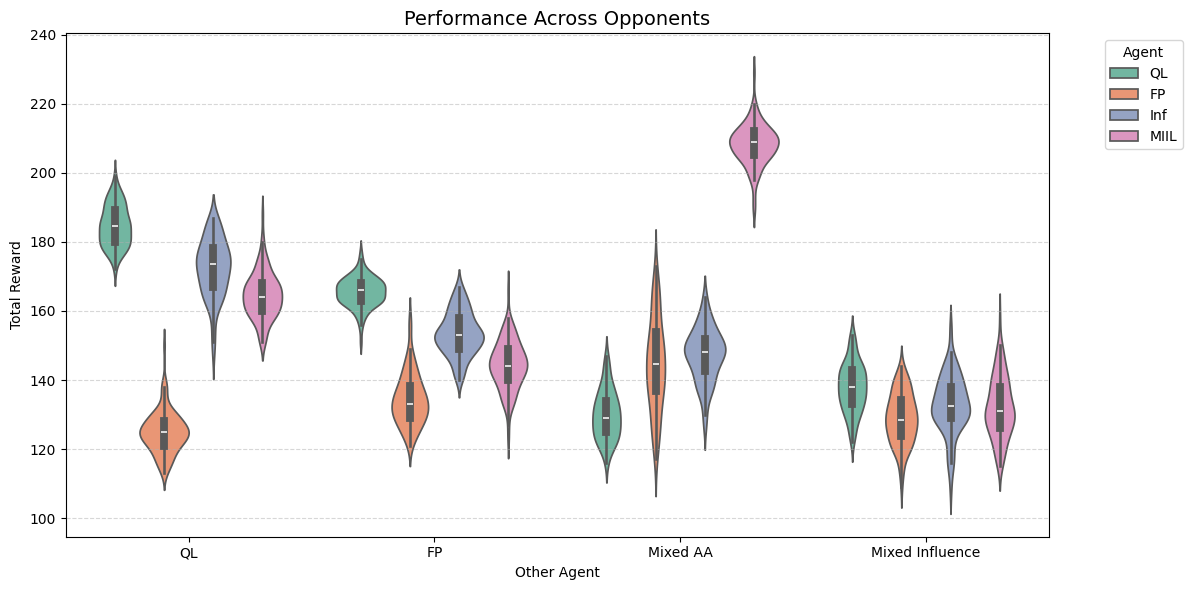

In [14]:
# Conversion to dataframes
df_models = pd.DataFrame(rewards_by_model)

# Violin plots
plt.figure(figsize=(12, 6))
sns.violinplot(x='Other Agent', y='Total Reward', hue='Model', data=df_models, split=False, palette='Set2')

# Style
plt.title('Performance Across Opponents', fontsize=14)
plt.ylabel('Total Reward')
plt.xlabel('Other Agent')
plt.legend(title='Agent', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


# Model Fitting

Models Pyro definition

In [15]:
def q_learning_pyro_model(actions, opponent_actions, rewards, in_dict = None):
    nb_trials = len(actions)
    def model():
        alpha = pyro.sample("alpha", dist.Normal(0.0, 1.0))
        beta = pyro.sample("beta", dist.Normal(0.0, 1.0))
        bias = pyro.sample("bias", dist.Normal(0.0, 1.0))
        Q = torch.zeros(2)
        theta = [alpha]
        phi = [beta, bias]

        for t in range(nb_trials):
            a = actions[t]
            r = rewards[t]
            probs = g_Qlearning(Q.detach().numpy(), torch.stack(phi).detach().numpy(), None, None)
            pyro.sample(f"action_{t}", dist.Categorical(torch.tensor([1-probs, probs])), obs=a)
            Qnp = f_Qlearning(Q.detach().numpy(), torch.stack(theta).detach().numpy(), [np.asarray(a), np.asarray(r)], None)
            Q = torch.tensor(Qnp, dtype=torch.float)

    return model

def fictitious_learner_pyro_model(actions, opponent_actions, rewards, in_dict = None):
    nb_trials = len(actions)
    def model():
        alpha = pyro.sample("alpha", dist.Normal(0.0, 1.0))
        beta = pyro.sample("beta", dist.Normal(0.0, 1.0))
        bias = pyro.sample("bias", dist.Normal(0.0, 1.0))
        Q = torch.zeros(2)
        theta = [alpha]
        phi = [beta, bias]

        for t in range(nb_trials):
            a = actions[t]
            r = rewards[t]
            probs = g_fictitious_learner(Q.detach().numpy(), torch.stack(phi).detach().numpy(), None, None)
            pyro.sample(f"action_{t}", dist.Categorical(torch.tensor([1-probs, probs])), obs=a)
            Qnp = f_fictitious_learner(Q.detach().numpy(), torch.stack(theta).detach().numpy(), [np.asarray(a), np.asarray(r)], None)
            Q = torch.tensor(Qnp, dtype=torch.float)

    return model

def influence_learning_pyro_model(actions, opponent_actions, rewards, in_dict):
    nb_trials = len(actions)
    def model():
        eta = pyro.sample("eta", dist.Normal(0.0, 1.))
        lambd = pyro.sample("lambd", dist.Normal(0.0, 1.))
        beta_opp = pyro.sample("beta_opp", dist.Normal(0.0, 1.))
        bias = pyro.sample("bias", dist.Normal(0.0,1.))
        beta = pyro.sample("beta", dist.Normal(0.0, 1.))

        x_init_val = sigmoid(torch.tensor(0.5), inverse=True)  # initial belief log-odds P(o=1)
        x = torch.tensor([x_init_val], dtype=torch.float)

        theta = [eta, lambd, beta_opp]
        phi = [beta, bias]
        # in_dict = {'game': game, 'player': player_role}

        for t in range(nb_trials):
            a = actions[t]
            o = opponent_actions[t]
            probs = g_influence_learner(x.detach().numpy(), torch.stack(phi).detach().numpy(), None, in_dict)
            pyro.sample(f"action_{t}", dist.Categorical(torch.tensor([1-probs, probs])), obs=a)
            xnp = f_influence_learner(x.detach().numpy(), torch.stack(theta).detach().numpy(), [np.asarray(o), np.asarray(a)], in_dict)
            x = torch.tensor(xnp, dtype=torch.float)

    return model

def MIIL_pyro_model(actions, opponent_actions, rewards, in_dict):
    nb_trials = len(actions)
    def model():
        eta = pyro.sample("eta", dist.Normal(0.0, 1.0))       # agent's prediction error weight
        lambd = pyro.sample("lambd", dist.Normal(0.0, 1.0))   # other's prediction error weight
        beta_opp = pyro.sample("beta_opp", dist.Normal(0.0, 1.0))     # opponent's softmax temp
        invprec = pyro.sample("invprec", dist.Normal(0.0, 1.0))  # game belief precision
        bias = pyro.sample("bias", dist.Normal(0.0, 1.0))
        beta1 = pyro.sample("beta1", dist.Normal(0.0, 1.0))
        beta2 = pyro.sample("beta2", dist.Normal(0.0, 1.0))

        # initial log-odds beliefs: [P(o=1|g1), P(o=1|g2), P(game1)]
        # Ensure x is a tensor with the expected initial shape, e.g., [3]
        x_init_val = sigmoid(0.5,inverse=True)
        x = torch.tensor([x_init_val] * 3, dtype=torch.float)

        theta = [eta, lambd, beta_opp, invprec, bias]
        phi = [beta1, beta2]
        # in_dict = {'game1': payoff_game1, 'game2': payoff_game2, 'player': player_role}

        for t in range(nb_trials):
            a = actions[t]
            o = opponent_actions[t]
            probs_a1 = g_MIIL(x.detach().numpy(), torch.stack(phi).detach().numpy(), None, in_dict)
            probs_a1 = float(np.clip(probs_a1, 1e-6, 1 - 1e-6).item()) # Clip to avoid 0 or 1 exactly

            # Create the probabilities tensor for the two actions [P(a=0), P(a=1)]
            action_probs = torch.tensor([1 - probs_a1, probs_a1])

            pyro.sample(f"action_{t}", dist.Categorical(action_probs), obs=a)
            xnp = f_MIIL(x.detach().numpy(), torch.stack(theta).detach().numpy(), [np.asarray(o), np.asarray(a)], in_dict)
            x = torch.tensor(xnp, dtype=torch.float)

    return model


Guide functions (Sets priors about learning parameters before fitting)

In [16]:
def guide_Qlearn():
    alpha_loc = pyro.param("alpha_loc", torch.tensor(0.0))
    beta_loc = pyro.param("beta_loc", torch.tensor(0.0))
    bias_loc = pyro.param("bias_loc", torch.tensor(0.0))
    pyro.sample("alpha", dist.Normal(alpha_loc,1.0))
    pyro.sample("beta", dist.Normal(beta_loc,1.0))
    pyro.sample("bias", dist.Normal(bias_loc,1.0))


def guide_FPlayer():
    alpha_loc = pyro.param("alpha_loc", torch.tensor(0.0))
    beta_loc = pyro.param("beta_loc", torch.tensor(0.0))
    bias_loc = pyro.param("bias_loc", torch.tensor(0.0))
    pyro.sample("alpha", dist.Normal(alpha_loc,1.0))
    pyro.sample("beta", dist.Normal(beta_loc,1.0))
    pyro.sample("bias", dist.Normal(bias_loc,1.0))


def guide_influence_learning():
    eta_loc = pyro.param("eta_loc", torch.tensor(0.0))
    pyro.sample("eta", dist.Normal(eta_loc,1.0))
    lambd_loc = pyro.param("lambd_loc", torch.tensor(0.0))
    pyro.sample("lambd", dist.Normal(lambd_loc,1.0))
    beta_opp_loc = pyro.param("beta_opp_loc", torch.tensor(0.0))
    pyro.sample("beta_opp", dist.Normal(beta_opp_loc,1.0))
    beta_loc = pyro.param("beta_loc", torch.tensor(0.0))
    pyro.sample("beta", dist.Normal(beta_loc,1.0))
    bias_loc = pyro.param("bias_loc", torch.tensor(0.0))
    pyro.sample("bias", dist.Normal(bias_loc,1.0))


def guide_MIIL():
    eta_loc = pyro.param("eta_loc", torch.tensor(0.0))
    pyro.sample("eta", dist.Normal(eta_loc,1.0))
    lambd_loc = pyro.param("lambd_loc", torch.tensor(0.0))
    pyro.sample("lambd", dist.Normal(lambd_loc,1.0))
    beta_opp_loc = pyro.param("beta_opp_loc", torch.tensor(0.0))
    pyro.sample("beta_opp", dist.Normal(beta_opp_loc,1.0))
    invprec_loc = pyro.param("invprec_loc", torch.tensor(0.0))
    pyro.sample("invprec", dist.Normal(invprec_loc,1.0))
    bias_loc = pyro.param("bias_loc", torch.tensor(0.0))
    pyro.sample("bias", dist.Normal(bias_loc,1.0))
    beta1_loc = pyro.param("beta1_loc", torch.tensor(0.0))
    pyro.sample("beta1", dist.Normal(beta1_loc,1.0))
    beta2_loc = pyro.param("beta2_loc", torch.tensor(0.0))
    pyro.sample("beta2", dist.Normal(beta2_loc,1.0))



Individual fitting functions

In [17]:
def fit_model(data, model_fn, guide_fn, in_dict = None, n_steps=1000):
    a = torch.tensor(data['agent1_action'].values, dtype=torch.long)
    o = torch.tensor(data['agent2_action'].values, dtype=torch.long)
    r = torch.tensor(data['agent1_reward'].values, dtype=torch.float)

    # Reset param store for each fitting
    pyro.clear_param_store()

    model = model_fn(a, o, r, in_dict)
    optimizer = Adam({"lr": 0.01})

    svi = SVI(model=model, guide=guide_fn, optim=optimizer, loss=pyro.infer.Trace_ELBO())

    losses = []
    for step in range(n_steps):
        loss = svi.step()
        losses.append(loss)

    # Extract parameters
    param_store = pyro.get_param_store()
    fitted_params = {name: param_store[name].detach().cpu().item() for name in param_store}

    # Predict choice probabilities using learned parameters
    # pred_probs = simulate_fct_choice_probs(model_fn, fitted_params)
    # pred_probs = simulate_from_model(model_sim_fn, fitted_params)

    return {
        "params": {name: pyro.param(name).item() for name in pyro.get_param_store().keys()},
        "elbo": losses[-1],
        "guide": guide_fn,
        "losses": losses,
        # "choice_probs": pred_probs
    }

Initialization

In [18]:
pyro_models = {
    "QL": (q_learning_pyro_model, guide_Qlearn),
    "FP": (fictitious_learner_pyro_model, guide_FPlayer),
    "Inf": (influence_learning_pyro_model, guide_influence_learning),
    "MIIL": (MIIL_pyro_model, guide_MIIL)
}

# results = {model: [] for model in pyro_models}
results = []

# 2x2x2 payoff tables: [agent_action, opponent_action, player_role]
# Example: Payoff[0,1,0] = payoff for player 1 when they pick 0 and other picks 1
HaS_game = np.zeros((2,2,2))
HaS_game[:,:,0] = [[1, 0], [0, 1]]  # Payoff for Player 1
HaS_game[:,:,1] = [[0, 1], [1, 0]]  # Payoff for Player 2 (opposite)

CG_game = np.zeros((2,2,2))
CG_game[:,:,0] = [[1, 0], [0, 1]]  # Payoff for Player 1
CG_game[:,:,1] = [[1, 0], [0, 1]]  # Payoff for Player 2


Fit all simulated participants

In [ ]:
# Collect unique models
all_models = set(pyro_models.keys())

for sim_model in all_models:
    print((f"Simulated model: {sim_model}"))
    sim = 0
    for entry in full_sims_hist:
        if entry['Model'] == sim_model and entry['Other Agent'] == 'QL' and sim < 10:
            for fitted_model_name, (model_fn, guide_fn) in pyro_models.items():
                print((f"Fitting model {fitted_model_name}"))
                hist = pd.DataFrame(entry['History'])
                data = {'agent1_action': hist['agent1_action'], 'agent2_action': hist['agent2_action'], 'agent1_reward': hist['agent1_reward']}

                if(fitted_model_name=="MIIL"):
                    in_dict = {'game1': CG_game, 'game2': HaS_game, 'player': 1}
                elif(fitted_model_name=="Inf"):
                    in_dict = {'game': CG_game, 'player': 1}
                else:
                    in_dict = None

                result = fit_model(data = data, model_fn = model_fn, guide_fn = guide_fn, in_dict = in_dict)
                results.append({'Simulated model': sim_model, 'Fitted model': fitted_model_name, 'Sim_nb': sim, 'Model fit result': result})
            sim = sim + 1
            print(fitted_model_name)


Simulated model: MIIL
Fitting model QL
Fitting model FP
Fitting model Inf


C:\Users\tnong\AppData\Local\Temp\ipykernel_25852\1097485954.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.log(x / (1 - x))


Fitting model MIIL


FFX Group-Level Model Comparison via Free Energy (ELBO)

In [ ]:
# Sum negative ELBOs across participants
log_evidence = {model: sum(np.mean(r["losses"]) for r in result_list) for model, result_list in results.items()}

# Convert to probabilities
names = list(log_evidence.keys())
logvals = np.array([log_evidence[n] for n in names])
probs = np.exp(logvals - logvals.max())
probs /= probs.sum()

print("Bayesian Model Comparison (FFX):")
for name, p in zip(names, probs):
    print(f"{name}: {p:.3f}")

RFX Group-Level Model Comparison via Free Energy (ELBO)

In [ ]:
# Convert Free Energies to Per-Participant Posterior Model Probabilities
def compute_rfx_model_probabilities(elbos_dict):
    """
    elbos_dict: dict of model_name -> list of per-participant ELBOs
    """
    model_names = list(elbos_dict.keys())
    K = len(model_names)
    N = len(next(iter(elbos_dict.values())))

    # Log model evidences (negative ELBO)
    log_model_evidences = np.zeros((N, K))
    for k, model in enumerate(model_names):
        log_model_evidences[:, k] = np.array([np.mean(res["losses"]) for res in elbos_dict[model]])

    # Normalize log evidences per participant to get P(model|data)
    log_evs = log_model_evidences - log_model_evidences.max(axis=1, keepdims=True)
    probs = np.exp(log_evs)
    probs /= probs.sum(axis=1, keepdims=True)  # N x K

    return probs, model_names

# Estimate Dirichlet Parameters (Frequency Inference via VB)
def estimate_dirichlet_rfx(probs, max_iter=100, tol=1e-4):
    """
    RFX VB estimation of model frequencies.
    probs: NxK matrix of participant-level model posterior probabilities.
    Returns: Dirichlet alphas and exceedance probabilities.
    """
    from scipy.special import digamma, polygamma

    N, K = probs.shape
    alpha = np.ones(K)

    for _ in range(max_iter):
        alpha_prev = alpha.copy()
        E_log_r = digamma(alpha) - digamma(np.sum(alpha))
        r_nk = np.exp(np.log(probs + 1e-16) + E_log_r)
        r_nk /= r_nk.sum(axis=1, keepdims=True)

        alpha = r_nk.sum(axis=0)
        alpha[alpha <= 0] = 1e-6

        if np.linalg.norm(alpha - alpha_prev) < tol:
            break

    exceedance_probs = compute_exceedance_prob(alpha);
    return alpha, exceedance_probs

def compute_exceedance_prob(alpha, n_samples=1_000_000):
    """
    Exceedance probability: P(model_k > all others)
    """
    # print(alpha)
    samples = np.random.dirichlet(alpha, size=n_samples)
    best = np.argmax(samples, axis=1)
    return np.bincount(best, minlength=len(alpha)) / n_samples

# To Visualize model frequencies (alpha) and exceedance probabilities
def bootstrap_alphas(probs, n_boot=100):
    """
    Bootstraps alpha estimates from resampled participant probabilities.
    Returns:
        mean_alphas: K-dimensional array
        ci_lower, ci_upper: 95% confidence intervals (K,)
    """
    N = probs.shape[0]
    K = probs.shape[1]
    alpha_samples = np.zeros((n_boot, K))

    for i in range(n_boot):
        resampled = probs[np.random.choice(N, N, replace=True)]
        alpha_i, _ = estimate_dirichlet_rfx(resampled)
        alpha_samples[i] = alpha_i

    mean_alpha = np.mean(alpha_samples, axis=0)
    ci_lower = np.percentile(alpha_samples, 2.5, axis=0)
    ci_upper = np.percentile(alpha_samples, 97.5, axis=0)
    return mean_alpha, ci_lower, ci_upper

def plot_rfx_model_comparison_with_ci(model_names, alphas, exceedance_probs, ci_lower, ci_upper):
    """
    Plot RFX model comparison with confidence intervals on alphas.
    """
    K = len(model_names)
    colors = sns.color_palette("Set2", K)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # α plot with CI
    lower_errors = np.maximum(0, alphas - ci_lower) # Ensure non-negative error bar length
    upper_errors = np.maximum(0, ci_upper - alphas) # Ensure non-negative error bar length

    axes[0].bar(model_names, alphas, color=colors, yerr=[lower_errors, upper_errors],
                capsize=5, ecolor='black')
    axes[0].set_title("Estimated Model Frequencies (Dirichlet α)")
    axes[0].set_ylabel("α")
    axes[0].set_ylim(0, max(ci_upper) * 1.2)

    # Exceedance probabilities
    axes[1].bar(model_names, exceedance_probs, color=colors)
    axes[1].set_title("Exceedance Probabilities")
    axes[1].set_ylabel("P(model > all others)")
    axes[1].set_ylim(0, 1.0)

    plt.tight_layout()
    plt.show()


Full model comparison pipeline

In [ ]:
# Step 1: Convert ELBOs to per-participant posteriors
probs, model_names = compute_rfx_model_probabilities(results)

# Step 2: Estimate RFX model frequencies
alphas, xp = estimate_dirichlet_rfx(probs)

# Step 3: Report
print("\nRFX Model Comparison:")
for name, a, p in zip(model_names, alphas, xp):
    print(f"{name}: alpha={a:.2f}, exceedance prob={p:.3f}")

# Bootstrapping
mean_alpha, ci_low, ci_high = bootstrap_alphas(probs)

# Plotting
plot_rfx_model_comparison_with_ci(model_names, mean_alpha, xp, ci_low, ci_high)
